In [26]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt


In [27]:
df = pd.read_csv("uber.csv")
print("Original rows:", len(df))

Original rows: 200000


In [8]:
# 3️ Basic cleaning
df = df.dropna()  # remove missing values
df = df[(df['fare_amount'] > 0) & (df['passenger_count'] > 0)]  # valid fares & passengers

In [9]:
# 4️⃣ Create a new column for distance (Haversine formula) these code calculates the real distance between pickup and drop.
def distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df['distance_km'] = distance(df['pickup_latitude'], df['pickup_longitude'],
                             df['dropoff_latitude'], df['dropoff_longitude'])

In [10]:
# 5️⃣ Outlier removal using IQR
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['fare_amount'] >= Q1 - 1.5*IQR) & (df['fare_amount'] <= Q3 + 1.5*IQR)]
print("Rows after removing outliers:", len(df))

Rows after removing outliers: 182148


In [11]:
# 6️⃣ Extract time features
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df['hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek

In [12]:
# 7️⃣ Select features and target
X = df[['distance_km', 'passenger_count', 'hour', 'dayofweek']]
y = df['fare_amount']

In [13]:
# 8️⃣ Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# 9️⃣ Train Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [15]:
# 🔟 Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [20]:
def evaluate(name, actual, predicted):
    r2 = r2_score(actual, predicted)
    rmse = mean_squared_error(actual, predicted, squared=False)
    mae = mean_absolute_error(actual, predicted)
    print(f"{name} -> R2: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

evaluate("Linear Regression", y_test, y_pred_lr)
evaluate("Random Forest", y_test, y_pred_rf)

Linear Regression -> R2: 0.001, RMSE: 4.128, MAE: 3.283
Random Forest -> R2: 0.633, RMSE: 2.503, MAE: 1.788


D:\jupyter notebook\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\jupyter notebook\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


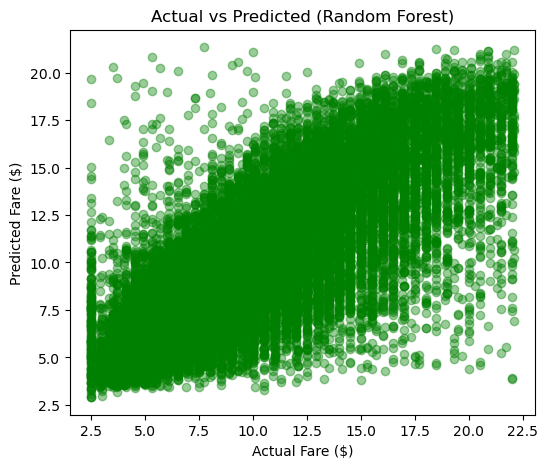

In [21]:
# 1️⃣2️⃣ Compare visually
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.4)
plt.xlabel("Actual Fare ($)")
plt.ylabel("Predicted Fare ($)")
plt.title("Actual vs Predicted (Random Forest)")
plt.show()